##                                          Diabetes Prediction

In [171]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
                        precision_score, recall_score, f1_score, 
                        accuracy_score,roc_auc_score)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

data = pd.read_csv("Diabetes_raw_dataset.csv")
print("Data: " + str(data.shape))

Data: (500, 16)


# Data Preprocessing

In [172]:
data.describe()

,Patient number,Cholesterol (mg/dl),Glucose (mg/dl),HDL Chol (mg/dl),TChol/HDL ratio,Age,Height /stature (cm),weight1 (Kg),weight2(Kg),BMI (Kg/m^2),Systolic BP,Diastolic BP,waist (cm),hip (cm)
count,500.000000,499.000000,499.000000,499.000000,499.000000,500.000000,500.000000,500.00000,500.000000,500.000000,498.000000,498.000000,500.00000,500.000000
mean,250.500000,208.248497,128.074148,50.336673,4.467936,46.488000,166.934600,82.46394,80.028000,29.694020,139.672691,82.672691,95.82800,109.113200
std,144.481833,50.676848,414.073059,17.141593,1.652604,17.629278,14.551164,46.39359,18.888111,18.010717,56.976674,13.599003,15.86429,14.299882
min,1.000000,2.000000,48.000000,1.000000,1.500000,19.000000,0.000000,0.00000,0.000000,0.000000,90.000000,48.000000,0.00000,76.200000
25%,125.750000,178.000000,81.000000,39.000000,3.200000,31.000000,160.000000,68.10000,68.000000,22.980000,120.000000,74.000000,83.80000,99.100000
50%,250.500000,204.000000,89.000000,46.000000,4.200000,43.000000,167.600000,79.00000,78.000000,28.130000,136.000000,82.000000,94.00000,106.700000
75%,375.250000,229.500000,106.500000,59.000000,5.300000,61.000000,175.300000,90.80000,90.000000,33.830000,148.000000,90.000000,104.10000,116.800000
max,500.000000,500.000000,9091.000000,120.000000,19.300000,92.000000,193.000000,996.98000,148.000000,377.280000,1140.000000,124.000000,142.20000,162.600000


We can observe that there are few missing data and outliers in the data that can be identified by the min and max values. 

In [173]:
data.head(5)

,Patient number,Cholesterol (mg/dl),Glucose (mg/dl),HDL Chol (mg/dl),TChol/HDL ratio,Age,Gender,Height /stature (cm),weight1 (Kg),weight2(Kg),BMI (Kg/m^2),Systolic BP,Diastolic BP,waist (cm),hip (cm),Diabetes
0,1,193.0,77.0,49.0,3.9,19,female,154.9,54.93,54,22.88,118.0,70.0,81.3,96.5,No diabetes
1,2,146.0,79.0,41.0,3.6,19,female,152.4,98.97,61,42.61,108.0,58.0,83.8,101.6,No diabetes
2,3,217.0,75.0,54.0,4.0,20,female,170.2,116.22,85,40.13,110.0,72.0,101.6,114.3,No diabetes
3,4,226.0,97.0,70.0,3.2,20,female,162.6,54.03,52,20.44,122.0,64.0,78.7,99.1,No diabetes
4,5,164.0,91.0,67.0,2.4,20,female,177.8,83.08,64,26.28,122.0,86.0,81.3,99.1,No diabetes


We can observe that the Gender and Diabetes fields are of string datatype that can be converted into integers for simplicity and to boost the model performance.

In [174]:
data['Gender'] = data['Gender'].replace({"male": 1, "female": 2})
data['Diabetes'] = data['Diabetes'].replace({"No diabetes": 0, "Diabetes": 1}) #binary classification
#comment out to remove deduplication as the spec says it belong to 500 indidivual patient records
#drop all duplicates
#data.drop_duplicates(subset=data.columns.difference(['Patient number']), keep='first', inplace=True)
#data.describe()
#columns_to_check = [' Cholesterol (mg/dl)','HDL Chol (mg/dl)', 'TChol/HDL ratio', 'Gender','Systolic BP','Diastolic BP','Diabetes']
#for col in columns_to_check:
#    duplicates_index = data[data.duplicated(subset=data.columns.difference(['Patient number',col]), keep=False) & data[col].isnull()].index
#    data.drop(index = duplicates_index, inplace = True)
#data.describe()



Check and update the nulls and zeros in the data with mean for the possible attributes.Though there are outliers in weight1 and systolic BP, its minimal and mean would be ideal than to consider median to replace nulls and 0 values in those attributes as well

In [175]:
for i in ['Height /stature (cm)','weight1 (Kg)','weight2(Kg)','waist (cm)','Glucose (mg/dl)','TChol/HDL ratio','Systolic BP','Diastolic BP',' Cholesterol (mg/dl)','HDL Chol (mg/dl)']:
    average_val = round(data[i].mean(),2)
    data.loc[(data[i] == 0) | (data[i].isnull()), i] = average_val
data.describe()

,Patient number,Cholesterol (mg/dl),Glucose (mg/dl),HDL Chol (mg/dl),TChol/HDL ratio,Age,Gender,Height /stature (cm),weight1 (Kg),weight2(Kg),BMI (Kg/m^2),Systolic BP,Diastolic BP,waist (cm),hip (cm),Diabetes
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,495.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,493.000000
mean,250.500000,208.248500,128.074140,50.336680,4.467940,46.488000,1.571717,167.60232,82.793780,80.348120,29.694020,139.672680,82.672680,96.211320,109.113200,0.148073
std,144.481833,50.626044,413.657948,17.124409,1.650947,17.629278,0.495331,9.97986,46.097727,18.193097,18.010717,56.862377,13.571724,14.653424,14.299882,0.355533
min,1.000000,2.000000,48.000000,1.000000,1.500000,19.000000,1.000000,132.10000,44.950000,45.000000,0.000000,90.000000,48.000000,66.000000,76.200000,0.000000
25%,125.750000,178.000000,81.000000,39.000000,3.200000,31.000000,1.000000,160.00000,68.100000,68.750000,22.980000,120.000000,74.000000,83.800000,99.100000,0.000000
50%,250.500000,204.000000,89.000000,46.000000,4.200000,43.000000,2.000000,167.60000,79.000000,78.500000,28.130000,136.000000,82.000000,94.000000,106.700000,0.000000
75%,375.250000,229.250000,107.250000,59.000000,5.300000,61.000000,2.000000,175.30000,90.800000,90.000000,33.830000,148.000000,90.000000,104.100000,116.800000,0.000000
max,500.000000,500.000000,9091.000000,120.000000,19.300000,92.000000,2.000000,193.00000,996.980000,148.000000,377.280000,1140.000000,124.000000,142.200000,162.600000,1.000000


Calculate the BMI based on the article provided with the weight and height of the patient. Following calculate the mode of the attributes Gender and Diabetes to update Nulls/0 in the attributes

In [176]:
#calc BMI when wieght and height are available
data.loc[data['BMI (Kg/m^2)'] == 0, 'BMI (Kg/m^2)'] = data.apply(lambda row: np.round(row['weight1 (Kg)'] / ((row['Height /stature (cm)']/100) ** 2), 2) if (row['Height /stature (cm)'] != 0) else 0, axis=1)

#calc mode and updating for gender and diabetes attribute
for i in ['Gender','Diabetes']:
    mode_val = data[i].mode()[0]
    data.loc[(data[i] == 0) | (data[i].isnull()), i] = mode_val
data.describe()


,Patient number,Cholesterol (mg/dl),Glucose (mg/dl),HDL Chol (mg/dl),TChol/HDL ratio,Age,Gender,Height /stature (cm),weight1 (Kg),weight2(Kg),BMI (Kg/m^2),Systolic BP,Diastolic BP,waist (cm),hip (cm),Diabetes
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000
mean,250.500000,208.248500,128.074140,50.336680,4.467940,46.488000,1.576000,167.60232,82.793780,80.348120,29.892080,139.672680,82.672680,96.211320,109.113200,0.14600
std,144.481833,50.626044,413.657948,17.124409,1.650947,17.629278,0.494685,9.97986,46.097727,18.193097,17.818071,56.862377,13.571724,14.653424,14.299882,0.35346
min,1.000000,2.000000,48.000000,1.000000,1.500000,19.000000,1.000000,132.10000,44.950000,45.000000,15.770000,90.000000,48.000000,66.000000,76.200000,0.00000
25%,125.750000,178.000000,81.000000,39.000000,3.200000,31.000000,1.000000,160.00000,68.100000,68.750000,23.117500,120.000000,74.000000,83.800000,99.100000,0.00000
50%,250.500000,204.000000,89.000000,46.000000,4.200000,43.000000,2.000000,167.60000,79.000000,78.500000,28.130000,136.000000,82.000000,94.000000,106.700000,0.00000
75%,375.250000,229.250000,107.250000,59.000000,5.300000,61.000000,2.000000,175.30000,90.800000,90.000000,33.830000,148.000000,90.000000,104.100000,116.800000,0.00000
max,500.000000,500.000000,9091.000000,120.000000,19.300000,92.000000,2.000000,193.00000,996.980000,148.000000,377.280000,1140.000000,124.000000,142.200000,162.600000,1.00000


The data is complete after the above updates as seen in the describe output

The correlation between the attribute can help understand the key attributes for predicting the outcome(diabetes) and the correlation between attributes within the dataset

In [177]:
corr = data.corr()
corr[corr == 1] = np.nan
corr_u = corr.unstack().dropna().drop_duplicates().sort_values(ascending=False)
print(corr_u[corr_u > 0.25])

weight1 (Kg)          BMI (Kg/m^2)       0.975958
weight2(Kg)           waist (cm)         0.837492
waist (cm)            hip (cm)           0.834521
weight2(Kg)           hip (cm)           0.817174
Patient number        Age                0.489980
 Cholesterol (mg/dl)  TChol/HDL ratio    0.394853
TChol/HDL ratio       waist (cm)         0.309864
Age                   Diabetes           0.309828
Height /stature (cm)  weight2(Kg)        0.283791
TChol/HDL ratio       weight2(Kg)        0.281974
Systolic BP           Diastolic BP       0.279071
TChol/HDL ratio       Diabetes           0.260108
dtype: float64


The Age and TChol/HDL ratio  correlate most with the Diabetes attribute, BMI, weight1, weight2, waist, hip, cholestrol, height,systolic and diastolic BP are also import features for trianing our model



Now based on the articles provided, reusable functions are created to classify the risk status of the patient based on gender, BMI, waist circumference, waist to hip ratio, waist to stature ratio, Blood pressure and Age.

In [178]:
#update Risk status based on the articles
def calculate_risk_status_bmi(bmi, gender):
    if gender == 1:
        if bmi > 27.08:
            return 3
        elif bmi >= 25.34 and bmi <= 27.07:
            return 2
        elif bmi >= 23.43 and bmi < 25.33:
            return 1
        else:
            return 0
    elif gender == 2:
        if bmi > 27.77:
            return 3
        elif bmi >= 25.30 and bmi <= 27.76:
            return 2
        elif bmi >= 22.96 and bmi < 25.29:
            return 1
        else:
            return 0
    else:
        return "Invalid"

def calculate_risk_factor_wc(waist, gender):
    if gender == 1:
        if waist > 97:
            return 3
        elif waist >= 92 and waist < 97:
            return 2
        elif waist >= 86 and waist < 92:
            return 1
        else:
            return 0
    elif gender == 2:
        if waist > 94:
            return 3
        elif waist >= 88 and waist < 94:
            return 2
        elif waist >= 81 and waist < 88:
            return 1
        else:
            return 0
    else:
        return "Invalid"
    
    
def calculate_risk_factor_whr(waist_hip_ratio, gender):
    if gender == 1:
        if waist_hip_ratio > 0.94:
            return 3
        elif waist_hip_ratio >= 0.91 and waist_hip_ratio < 0.94:
            return 2
        elif waist_hip_ratio >= 0.87 and waist_hip_ratio < 0.91:
            return 1
        else:
            return 0
    elif gender == 2:
        if waist_hip_ratio > 0.91:
            return 3
        elif waist_hip_ratio >= 0.86 and waist_hip_ratio < 0.91:
            return 2
        elif waist_hip_ratio >= 0.83 and waist_hip_ratio < 0.86:
            return 1
        else:
            return 0
    else:
        return "Invalid"

def calculate_risk_factor_wsr(waist_stature_ratio, gender):
    if gender == 1:
        if waist_stature_ratio > 0.57:
            return 3
        elif waist_stature_ratio >= 0.54 and waist_stature_ratio < 0.57:
            return 2
        elif waist_stature_ratio >= 0.51 and waist_stature_ratio < 0.54:
            return 1
        else:
            return 0
    elif gender == 2:
        if waist_stature_ratio > 0.60:
            return 3
        elif waist_stature_ratio >= 0.56 and waist_stature_ratio < 0.60:
            return 2
        elif waist_stature_ratio >= 0.51 and waist_stature_ratio < 0.56:
            return 1
        else:
            return 0
    else:
        return "Invalid"

def calculate_risk_factor_bp(diastolic,systolic):
    if diastolic > 90:
        return 3
    elif diastolic < 90 and systolic > 140:
        return 2
    else:
        return 0

def calculate_risk_factor_age(age):
    if age >= 65:
        return 2
    elif age >= 40 and age <= 64:
        return 3
    else:
        return 0


New attributes are added to calculate the risk status based on the supporting articles. Finally a new attribute named 'High_Risk' is added to considate the risk status of the patient based on the different attributes. If atleast one risk status is 3, then the High_risk attribute is set to 3 and respectively to all other risk status.

In [179]:
data["RF1"] = data.apply(lambda x: calculate_risk_status_bmi(x["BMI (Kg/m^2)"], x["Gender"]), axis=1)
data["RF2"] = data.apply(lambda x: calculate_risk_factor_wc(x["waist (cm)"], x["Gender"]), axis=1)
data["WHR"] = data["waist (cm)"]/data["hip (cm)"]
data["RF3"] = data.apply(lambda x: calculate_risk_factor_whr(x["WHR"], x["Gender"]), axis=1)
data["WSR"] = data["waist (cm)"]/data["Height /stature (cm)"]
data["RF4"] = data.apply(lambda x: calculate_risk_factor_wsr(x["WSR"], x["Gender"]), axis=1)
data["RF5"] = data.apply(lambda x: calculate_risk_factor_bp(x["Diastolic BP"], x["Systolic BP"]), axis=1)
data["RF6"] = data.apply(lambda x: calculate_risk_factor_age(x["Age"]), axis=1)
data['High_Risk'] = data[["RF1", "RF2", "RF3", "RF4", "RF5", "RF6"]].apply(lambda x: 3 if x.eq(3).any() else (2 if x.eq(2).any() else (1 if x.eq(1).any() else 0)), axis=1)
data = data.drop(columns=["WHR","WSR","RF1","RF2","RF3","RF4","RF5","RF6"])
data

,Patient number,Cholesterol (mg/dl),Glucose (mg/dl),HDL Chol (mg/dl),TChol/HDL ratio,Age,Gender,Height /stature (cm),weight1 (Kg),weight2(Kg),BMI (Kg/m^2),Systolic BP,Diastolic BP,waist (cm),hip (cm),Diabetes,High_Risk
0,1,193.0,77.0,49.0,3.9,19,2.0,154.9,54.93,54.0,22.88,118.0,70.0,81.3,96.5,0.0,1
1,2,146.0,79.0,41.0,3.6,19,2.0,152.4,98.97,61.0,42.61,108.0,58.0,83.8,101.6,0.0,3
2,3,217.0,75.0,54.0,4.0,20,2.0,170.2,116.22,85.0,40.13,110.0,72.0,101.6,114.3,0.0,3
3,4,226.0,97.0,70.0,3.2,20,2.0,162.6,54.03,52.0,20.44,122.0,64.0,78.7,99.1,0.0,0
4,5,164.0,91.0,67.0,2.4,20,2.0,177.8,83.08,64.0,26.28,122.0,86.0,81.3,99.1,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,155.0,58.0,69.0,2.2,26,1.0,185.4,72.19,79.0,21.00,110.0,76.0,76.2,88.9,0.0,0
496,497,179.0,90.0,60.0,3.0,26,2.0,152.4,93.07,59.0,40.07,138.0,84.0,81.3,101.6,0.0,3
497,498,283.0,83.0,74.0,3.8,26,1.0,182.9,65.83,103.0,19.68,158.0,104.0,104.1,111.8,0.0,3
498,499,228.0,79.0,37.0,6.2,26,1.0,182.9,97.16,118.0,29.05,122.0,90.0,121.9,124.5,0.0,3


<Figure size 2880x2880 with 0 Axes>

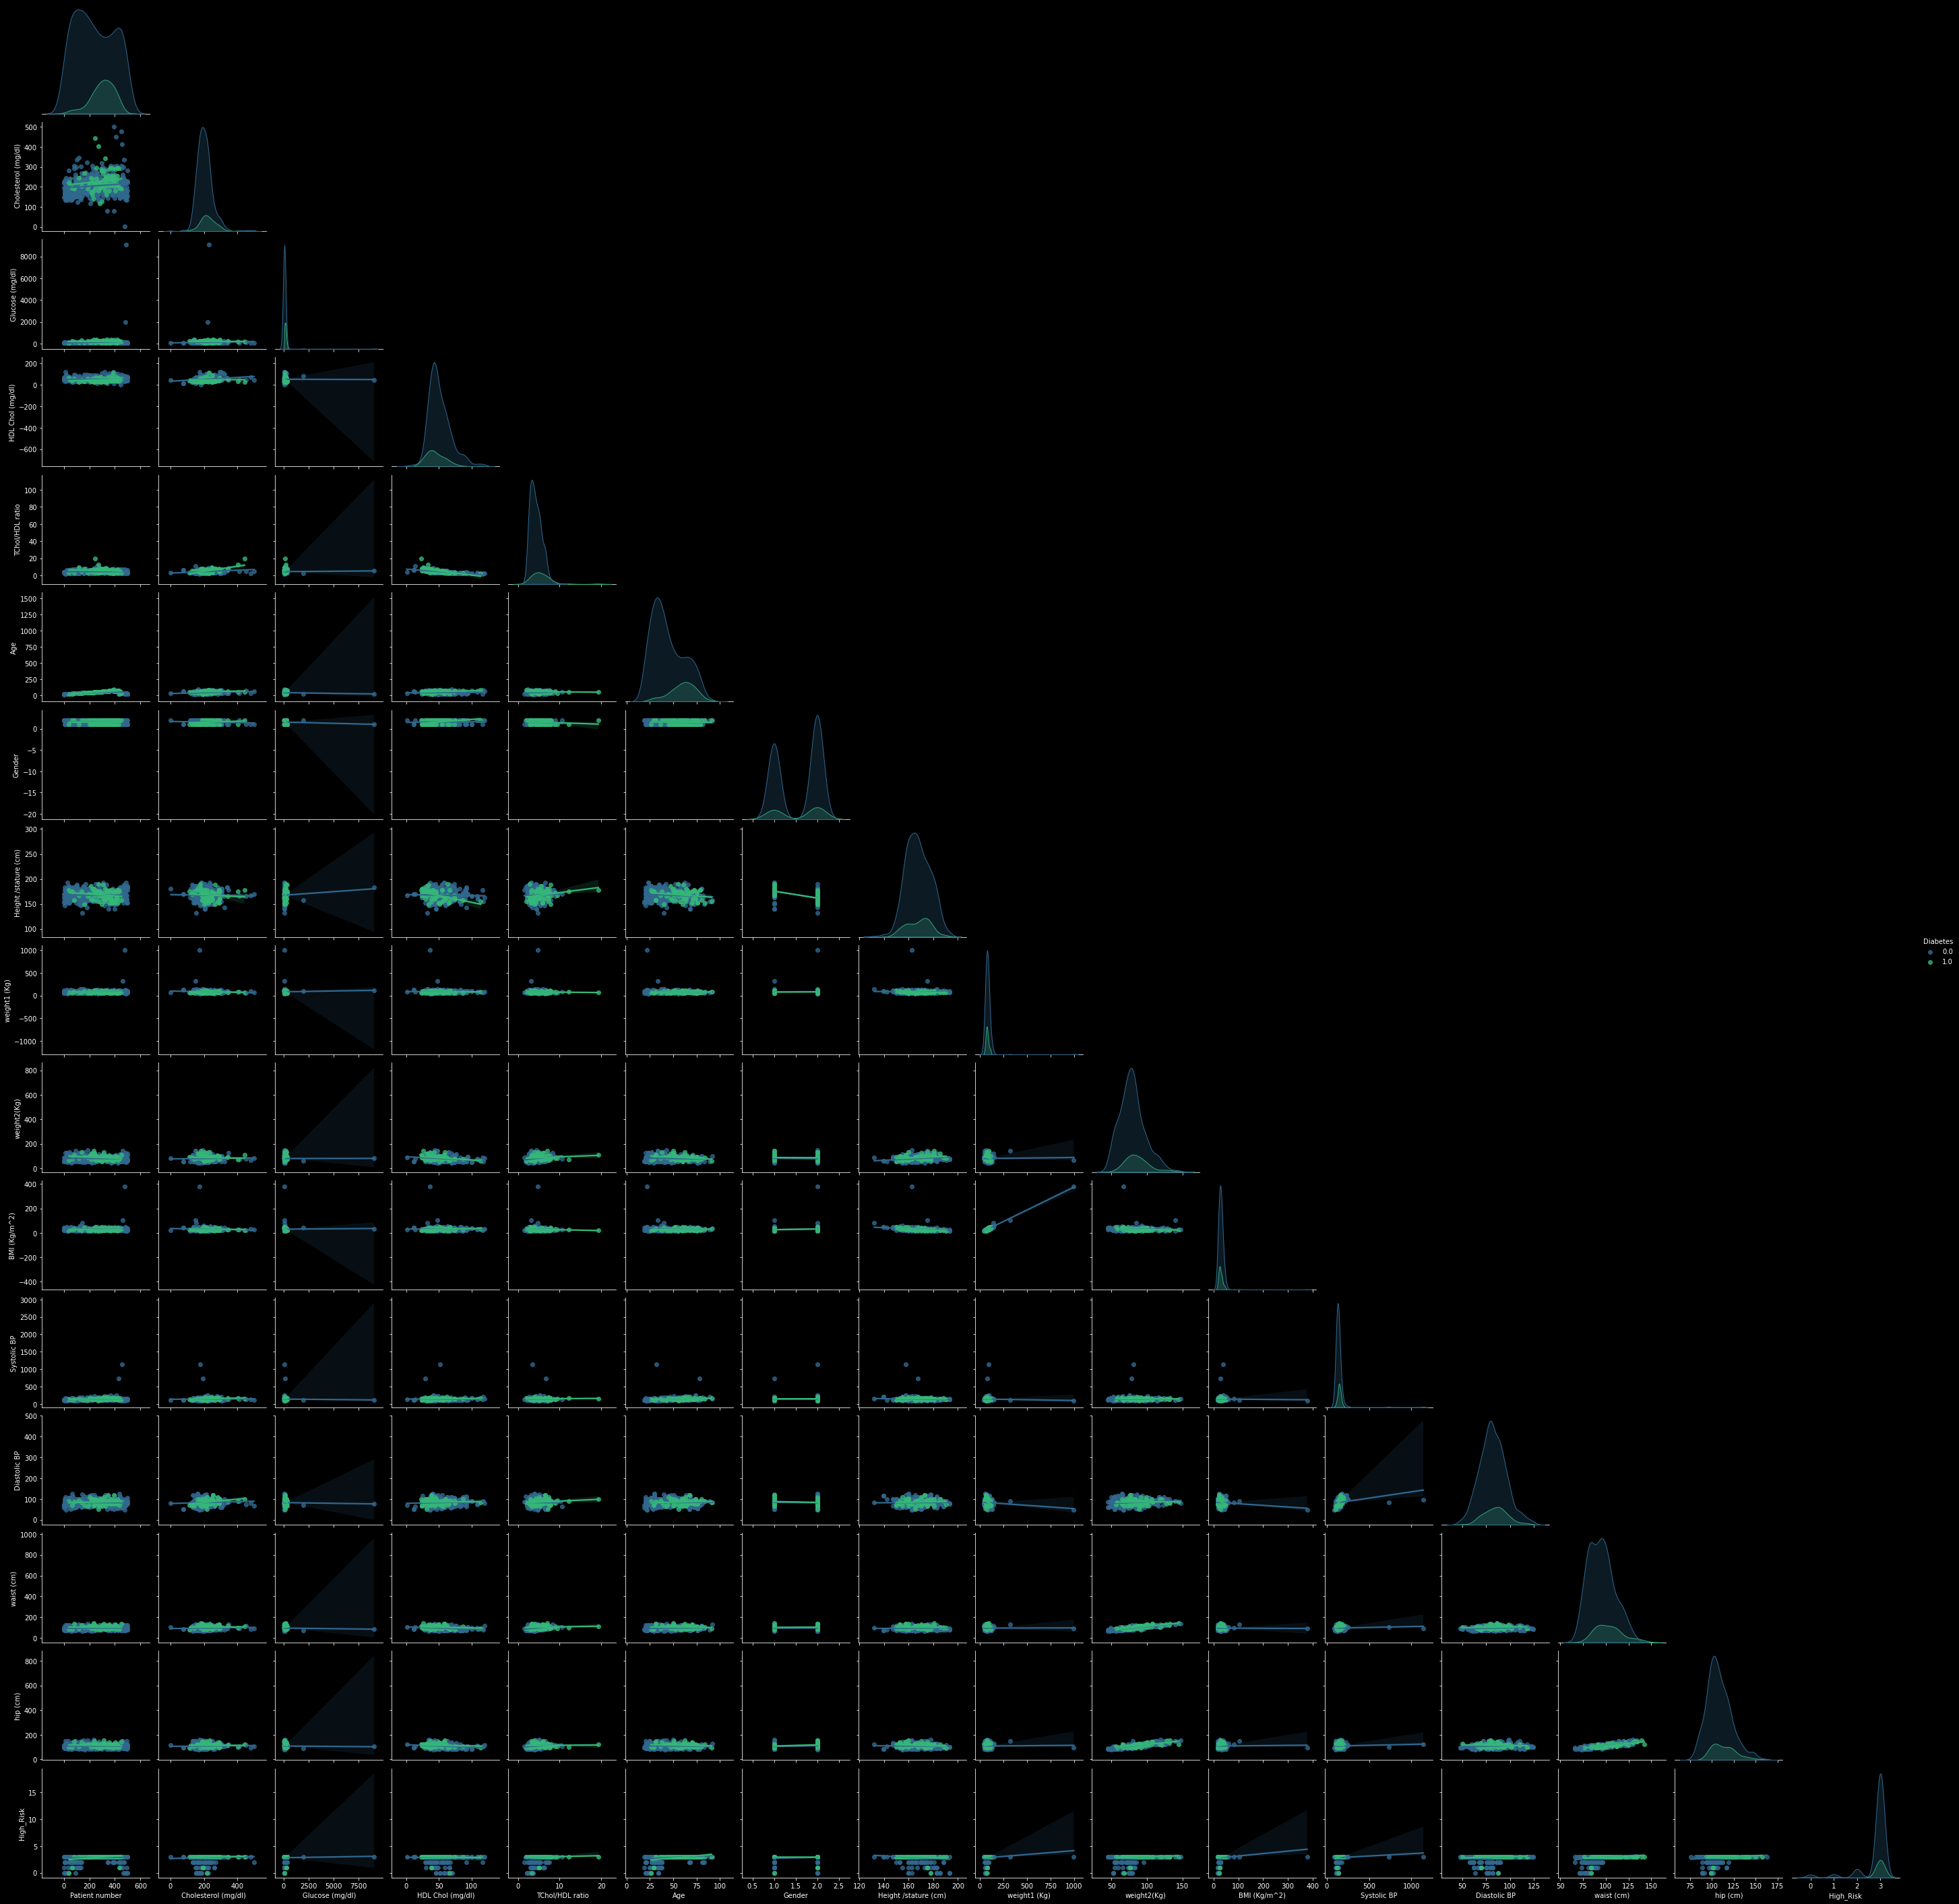

In [149]:
plt.figure(figsize = (40,40))
sns.reset_orig()
plt.style.use("dark_background")

sns.pairplot(data, kind = 'reg',corner = True, palette='viridis', hue='Diabetes')

The above scatter plot can be used to identify the relationship between different variables in the dataset to the Diabetes attribute., the regression line is for finding the strength and direction of the varibable in relation to Diabetes.

For easier interpreation, a heat map cna be used to rperesent the correlation after preprocessing

weight1 (Kg)          BMI (Kg/m^2)       0.975958
weight2(Kg)           waist (cm)         0.837492
waist (cm)            hip (cm)           0.834521
weight2(Kg)           hip (cm)           0.817174
Patient number        Age                0.489980
 Cholesterol (mg/dl)  TChol/HDL ratio    0.394853
TChol/HDL ratio       waist (cm)         0.309864
Age                   Diabetes           0.309828
waist (cm)            High_Risk          0.298369
Height /stature (cm)  weight2(Kg)        0.283791
TChol/HDL ratio       weight2(Kg)        0.281974
Systolic BP           Diastolic BP       0.279071
Age                   High_Risk          0.272091
TChol/HDL ratio       Diabetes           0.260108
dtype: float64


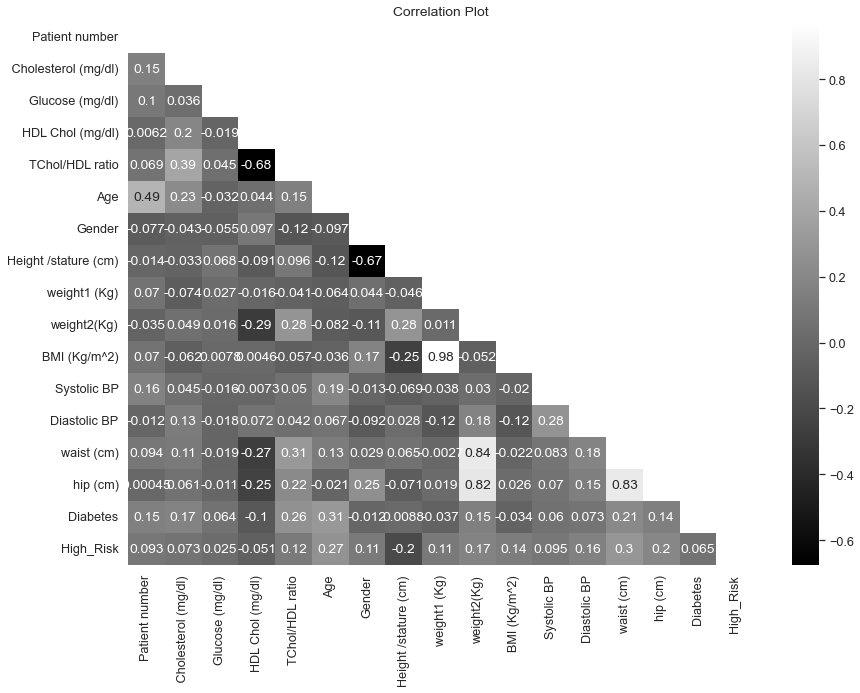

In [180]:
corr = data.corr()
corr[corr == 1] = np.nan

sns.set(font_scale=1.15)
plt.figure(figsize=(14, 10))
sns.set_palette("bright")
sns.set_style("white")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,cmap='gist_yarg_r',mask=mask,cbar=True)
plt.title('Correlation Plot')

corr_u = corr.unstack().dropna().drop_duplicates().sort_values(ascending=False)
print(corr_u[corr_u > 0.25])




The Age and TChol/HDL ratio are directly correlated to the Diabetes. The newly added High_Risk attribute is correlated with a number of other variables in the dataset. But its very lightly correlated with the outcome Diabetes and doesnt have a major impact in the dataset and therefore will not help improve performance vastly for the model.As suggested by the colleague it might be enough to preprocess the exising data to train the model. But it may be useful with a possible performance improvement and therefore I have decided ot keep it.



Plot to see the distribution of the outcome Diabetes in the dataset. There is an uneven distribution of positive to negative case in the dataset

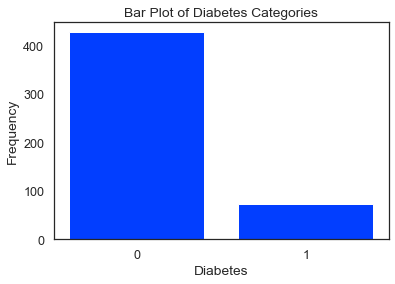

In [181]:
column = data['Diabetes']
plt.bar(['0', '1'], [column[column==0].count(), column[column==1].count()])
plt.ylabel('Frequency')
plt.xlabel('Diabetes')
plt.title('Bar Plot of Diabetes Categories')
plt.show()

## Split and Scale the data

In [182]:
#Split the data into training, validation and testing datasets and scale it based on the best possible scaling method using cross validation
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)
val_set, test_set =  train_test_split(test_set, test_size=0.33, random_state=42)
X_train = train_set.drop(['Diabetes'], axis=1)
y_train = train_set['Diabetes'].copy()
X_val = val_set.drop(['Diabetes'], axis=1)
y_val = val_set['Diabetes'].copy()
X_test = test_set.drop(['Diabetes'], axis=1)
y_test = test_set['Diabetes'].copy()
#X_train.info()
#X_val.info()
#X_test.info()
#y_train.head(10)
#y_test.count()
smote = SMOTE(random_state=42)
undersampler = RandomUnderSampler(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_train, y_train = undersampler.fit_resample(X_train, y_train)


In [183]:
#find the best scaling method to use
scaler_list = [MinMaxScaler(), StandardScaler(), RobustScaler()]
pipe = Pipeline([('scaler', MinMaxScaler()), ('classifier', SVC())])
param_grid = {'scaler': scaler_list}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipe, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best scaling method:", grid_search.best_params_['scaler'])


Best scaling method: StandardScaler()


In [184]:
std_scaler = StandardScaler()
transformer = std_scaler.fit(X_train)

Train_prep = transformer.transform(X_train)
X_train_prep = pd.DataFrame(Train_prep, columns=X_train.columns, index=X_train.index)
Val_prep = transformer.transform(X_val)
X_val_prep = pd.DataFrame(Val_prep, columns=X_val.columns, index=X_val.index)
Test_prep = transformer.transform(X_test)
X_test_prep = pd.DataFrame(Test_prep, columns=X_test.columns, index=X_test.index)

#X_test_prep.count()

## Training the model

In [185]:
#since the results are to be checked for all the models,creating reusable funct
def classifier_results(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred,zero_division=0)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print("Accuracy: {:.4f} Precision: {:.4f} Recall: {:.4f} F1: {:.4f} ROC-AUC: {:.4f}".format(accuracy,precision,recall,f1,roc_auc))
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(confusion, cmap = 'YlGnBu',annot = True, fmt='d')
    ax.set_title('Confusion Matrix')
    return confusion

#Hyperparameters tuned with validation dataset, This will help with overfitting 
def grid_search_cv(estimator, param_grid, cv=5, scoring='roc_auc'):
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, scoring=scoring)
    grid_search.fit(X_val_prep, y_val)
    return grid_search.best_params_


Training the model with hyperparameters tuned with the validation dataset. Since its costly, have commented out to prevent from re-execution everytime the code is run. The model is then trained with best parameter from GridSearchCV to get the best performance.

Training the models individually to find the performance and possible combination for a ensemble solution.

LogisticRegressor:

Accuracy: 0.7910 Precision: 0.1429 Recall: 0.5000 F1: 0.2222 ROC-AUC: 0.8810


array([[51, 12],
       [ 2,  2]], dtype=int64)

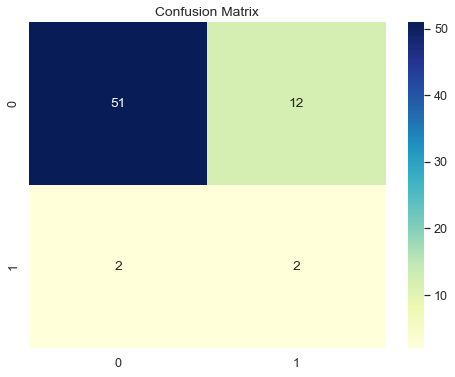

In [186]:
#Best_params = grid_search_cv(LogisticRegression(),{'C': [0.1, 1, 10],'penalty': ['l1', 'l2']},5,'roc_auc')
#print('Best params for Logistic Regression-' + str(Best_params))

LRClassifier = LogisticRegression(C= 0.1, penalty='l2', random_state=42)
LRClassifier.fit(X_train_prep, y_train)

y_val_pred_lr = LRClassifier.predict(X_val_prep)

pred_proba = LRClassifier.predict_proba(X_val_prep)[:,1]
classifier_results(y_val,y_val_pred_lr,pred_proba)


Support Vector Classifier (SVC)

In [187]:
#code not commented to display the execution of hyperparameter tuning. Its commented for all other models
Best_params = grid_search_cv(SVC(),{'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': [0.1, 1, 10],'degree': [2,3,4],
              'probability':[True]},5,'roc_auc')
print('Best params for SVC-' + str(Best_params))

Best params for SVC-{'C': 0.1, 'degree': 2, 'gamma': 0.1, 'kernel': 'linear', 'probability': True}


Accuracy: 0.8507 Precision: 0.2500 Recall: 0.7500 F1: 0.3750 ROC-AUC: 0.8849


array([[54,  9],
       [ 1,  3]], dtype=int64)

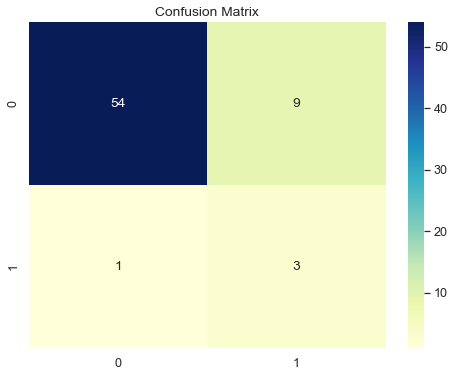

In [188]:
#tuned hyperparameters used for trianing the model
SVMClassifier = SVC(kernel='linear', gamma=0.1, C=0.1, degree=2, probability = True, random_state=42)
SVMClassifier.fit(X_train_prep, y_train)

y_val_pred_svm = SVMClassifier.predict(X_val_prep)

pred_proba = SVMClassifier.predict_proba(X_val_prep)[:,1]
classifier_results(y_val,y_val_pred_svm,pred_proba)



DecisionTreeClassifier

Accuracy: 0.8657 Precision: 0.2727 Recall: 0.7500 F1: 0.4000 ROC-AUC: 0.9544


array([[55,  8],
       [ 1,  3]], dtype=int64)

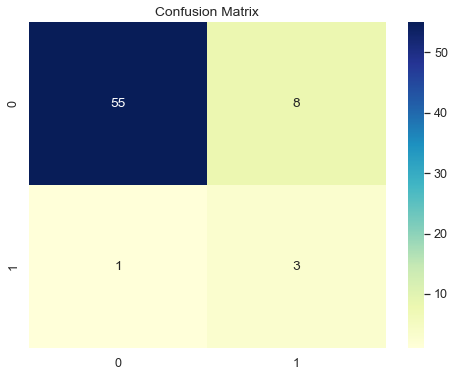

In [189]:
#hyperparameters tuned based on the below code and commented to prevent re-execution as its a costly function
#Best_params = grid_search_cv(DecisionTreeClassifier(),{'max_depth': [1, 5, 10, 20],
#              'max_features': [1, 5, 10, 20],
#              'min_samples_leaf': [1, 5, 10, 20]},5,'roc_auc')
#print('Best params for DecisionTree-' + str(Best_params))

DTClassifier = DecisionTreeClassifier(max_depth= 20, max_features= 5, min_samples_leaf= 10,random_state=42)
DTClassifier.fit(X_train_prep, y_train)
y_val_pred_dt = DTClassifier.predict(X_val_prep)

pred_proba = DTClassifier.predict_proba(X_val_prep)[:,1]
classifier_results(y_val,y_val_pred_dt,pred_proba)


RandomForestClassifier

Accuracy: 0.9403 Precision: 0.5000 Recall: 1.0000 F1: 0.6667 ROC-AUC: 0.9762


array([[59,  4],
       [ 0,  4]], dtype=int64)

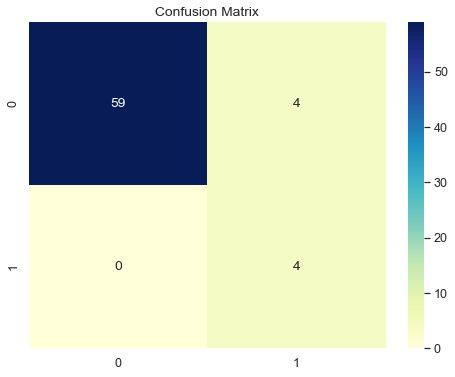

In [190]:
#hyperparameters tuned based on the below code and commented to prevent re-execution as its a costly function
#Best_params = grid_search_cv(RandomForestClassifier(),{'n_estimators': [50, 100, 200],
#              'max_depth': [5, 10, 20],
#              'criterion': ['gini', 'entropy'],
#              'min_samples_split': [2, 5, 10],
#              'bootstrap': [True, False]},5,'roc_auc')
#print('Best params for RandomForrest-' + str(Best_params))


RFclassifier = RandomForestClassifier(n_estimators = 100, max_depth = 10,criterion = 'entropy', min_samples_split = 10,bootstrap = False, random_state=42)
RFclassifier.fit(X_train_prep, y_train)

y_val_pred_dt = RFclassifier.predict(X_val_prep)

pred_proba = RFclassifier.predict_proba(X_val_prep)[:,1]
classifier_results(y_val,y_val_pred_dt,pred_proba)


AdaBoostClassifier

Accuracy: 0.9254 Precision: 0.4444 Recall: 1.0000 F1: 0.6154 ROC-AUC: 0.9861


array([[58,  5],
       [ 0,  4]], dtype=int64)

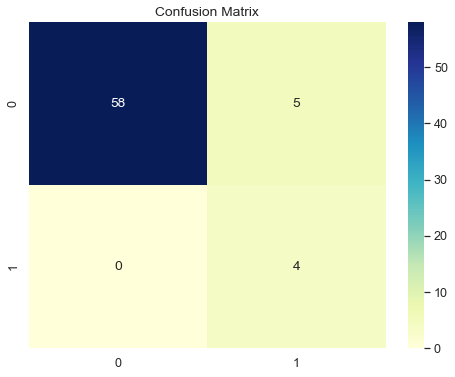

In [191]:
#hyperparameters tuned based on the below code and commented to prevent re-execution as its a costly function
#Best_params = grid_search_cv(AdaBoostClassifier(),{'algorithm': ['SAMME', 'SAMME.R'],
#              'learning_rate': [0.1, 0.5, 1.0],
#              'n_estimators': [50, 100, 200]},5,'roc_auc')
#print('Best params for AdaBoostClassifier-' + str(Best_params))


ABClassifier = AdaBoostClassifier(algorithm='SAMME', learning_rate=0.1, n_estimators= 200, random_state=42)
ABClassifier.fit(X_train_prep, y_train)
y_val_pred_dt = ABClassifier.predict(X_val_prep)

pred_proba = ABClassifier.predict_proba(X_val_prep)[:,1]
classifier_results(y_val,y_val_pred_dt,pred_proba)


GradientBoostingClassifier

Accuracy: 0.9254 Precision: 0.4444 Recall: 1.0000 F1: 0.6154 ROC-AUC: 0.9683


array([[58,  5],
       [ 0,  4]], dtype=int64)

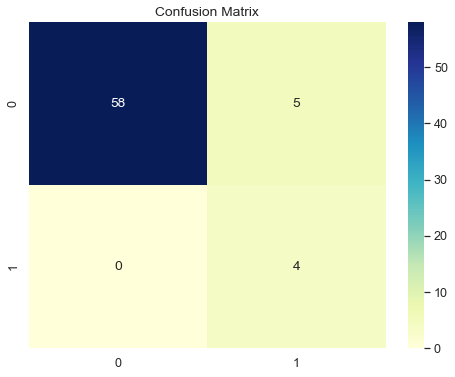

In [193]:
#hyperparameters tuned based on the below code and commented to prevent re-execution as its a costly function
#Best_params = grid_search_cv(GradientBoostingClassifier(),{'learning_rate': [0.1, 0.05, 0.01],
#              'max_depth': [4, 6, 8],
#              'n_estimators': [50, 100, 200],
#              'subsample': [0.5, 0.7, 1.0]},5,'roc_auc')
#print('Best params for GradientBoostingClassifier-' + str(Best_params))


GBClassifier = GradientBoostingClassifier(learning_rate=0.05, max_depth=6, n_estimators=50,subsample= 0.5, random_state=42)
GBClassifier.fit(X_train_prep, y_train)
y_val_pred_dt = GBClassifier.predict(X_val_prep)

pred_proba = GBClassifier.predict_proba(X_val_prep)[:,1]
classifier_results(y_val,y_val_pred_dt,pred_proba)


CatBoostClassifier

0:	learn: 0.6836113	total: 1.65ms	remaining: 1.65s
1:	learn: 0.6746900	total: 3.09ms	remaining: 1.54s
2:	learn: 0.6642450	total: 4.26ms	remaining: 1.41s
3:	learn: 0.6556906	total: 5.37ms	remaining: 1.34s
4:	learn: 0.6460922	total: 6.45ms	remaining: 1.28s
5:	learn: 0.6375291	total: 7.5ms	remaining: 1.24s
6:	learn: 0.6293674	total: 8.53ms	remaining: 1.21s
7:	learn: 0.6220716	total: 9.57ms	remaining: 1.19s
8:	learn: 0.6126475	total: 10.7ms	remaining: 1.17s
9:	learn: 0.6053546	total: 11.7ms	remaining: 1.16s
10:	learn: 0.5968113	total: 12.8ms	remaining: 1.15s
11:	learn: 0.5893048	total: 14ms	remaining: 1.16s
12:	learn: 0.5822088	total: 15.4ms	remaining: 1.17s
13:	learn: 0.5748485	total: 16.5ms	remaining: 1.16s
14:	learn: 0.5678205	total: 17.8ms	remaining: 1.17s
15:	learn: 0.5617465	total: 18.9ms	remaining: 1.16s
16:	learn: 0.5542964	total: 20ms	remaining: 1.16s
17:	learn: 0.5470502	total: 21.1ms	remaining: 1.15s
18:	learn: 0.5402870	total: 22.3ms	remaining: 1.15s
19:	learn: 0.5322423	total:

317:	learn: 0.1569289	total: 339ms	remaining: 727ms
318:	learn: 0.1566992	total: 340ms	remaining: 726ms
319:	learn: 0.1566553	total: 341ms	remaining: 726ms
320:	learn: 0.1563842	total: 343ms	remaining: 725ms
321:	learn: 0.1562053	total: 344ms	remaining: 723ms
322:	learn: 0.1560359	total: 345ms	remaining: 723ms
323:	learn: 0.1558589	total: 346ms	remaining: 722ms
324:	learn: 0.1557661	total: 347ms	remaining: 721ms
325:	learn: 0.1556364	total: 348ms	remaining: 720ms
326:	learn: 0.1554658	total: 349ms	remaining: 719ms
327:	learn: 0.1553841	total: 351ms	remaining: 718ms
328:	learn: 0.1552244	total: 352ms	remaining: 717ms
329:	learn: 0.1550808	total: 353ms	remaining: 716ms
330:	learn: 0.1549783	total: 354ms	remaining: 715ms
331:	learn: 0.1548616	total: 355ms	remaining: 714ms
332:	learn: 0.1548149	total: 356ms	remaining: 713ms
333:	learn: 0.1547715	total: 357ms	remaining: 712ms
334:	learn: 0.1545438	total: 358ms	remaining: 711ms
335:	learn: 0.1543230	total: 360ms	remaining: 711ms
336:	learn: 

482:	learn: 0.1294352	total: 510ms	remaining: 546ms
483:	learn: 0.1293923	total: 511ms	remaining: 545ms
484:	learn: 0.1288521	total: 512ms	remaining: 544ms
485:	learn: 0.1287393	total: 514ms	remaining: 543ms
486:	learn: 0.1284970	total: 515ms	remaining: 542ms
487:	learn: 0.1283921	total: 516ms	remaining: 541ms
488:	learn: 0.1282849	total: 517ms	remaining: 540ms
489:	learn: 0.1281745	total: 518ms	remaining: 539ms
490:	learn: 0.1280035	total: 519ms	remaining: 538ms
491:	learn: 0.1279524	total: 520ms	remaining: 537ms
492:	learn: 0.1279138	total: 522ms	remaining: 536ms
493:	learn: 0.1278048	total: 523ms	remaining: 535ms
494:	learn: 0.1277226	total: 524ms	remaining: 535ms
495:	learn: 0.1273526	total: 525ms	remaining: 534ms
496:	learn: 0.1272285	total: 526ms	remaining: 533ms
497:	learn: 0.1267727	total: 527ms	remaining: 531ms
498:	learn: 0.1266059	total: 528ms	remaining: 530ms
499:	learn: 0.1264360	total: 530ms	remaining: 530ms
500:	learn: 0.1263970	total: 531ms	remaining: 529ms
501:	learn: 

803:	learn: 0.0962589	total: 852ms	remaining: 208ms
804:	learn: 0.0962472	total: 853ms	remaining: 207ms
805:	learn: 0.0961037	total: 854ms	remaining: 206ms
806:	learn: 0.0957346	total: 855ms	remaining: 205ms
807:	learn: 0.0956771	total: 857ms	remaining: 204ms
808:	learn: 0.0956276	total: 858ms	remaining: 203ms
809:	learn: 0.0954670	total: 859ms	remaining: 201ms
810:	learn: 0.0953427	total: 860ms	remaining: 200ms
811:	learn: 0.0952805	total: 861ms	remaining: 199ms
812:	learn: 0.0951991	total: 862ms	remaining: 198ms
813:	learn: 0.0951870	total: 863ms	remaining: 197ms
814:	learn: 0.0951464	total: 864ms	remaining: 196ms
815:	learn: 0.0950738	total: 866ms	remaining: 195ms
816:	learn: 0.0949996	total: 867ms	remaining: 194ms
817:	learn: 0.0949627	total: 868ms	remaining: 193ms
818:	learn: 0.0949034	total: 869ms	remaining: 192ms
819:	learn: 0.0948921	total: 870ms	remaining: 191ms
820:	learn: 0.0948770	total: 872ms	remaining: 190ms
821:	learn: 0.0948236	total: 873ms	remaining: 189ms
822:	learn: 

array([[60,  3],
       [ 0,  4]], dtype=int64)

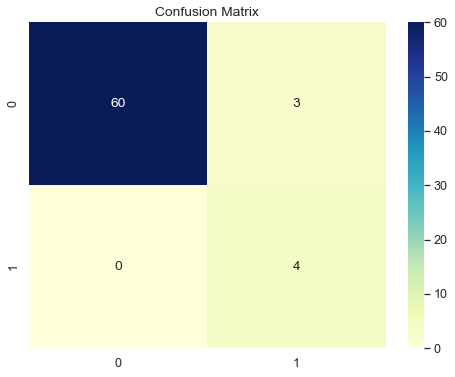

In [194]:
#hyperparameters tuned based on the below code and commented to prevent re-execution as its a costly function
#Best_params = grid_search_cv(CatBoostClassifier(),{'depth': [3, 4, 5], 'learning_rate': [0.1, 0.05, 0.01]},5,'roc_auc')
#print('Best params for CatBoostClassifier-' + str(Best_params))


CBClassifier = CatBoostClassifier(depth = 3,learning_rate=0.01,random_state=42)
CBClassifier.fit(X_train_prep, y_train)
y_val_pred_dt = CBClassifier.predict(X_val_prep)

pred_proba = CBClassifier.predict_proba(X_val_prep)[:,1]
classifier_results(y_val,y_val_pred_dt,pred_proba)


In [195]:
#from sklearn.naive_bayes import GaussianNB

#gnb = GaussianNB(var_smoothing= 1e-09)
#Best_params = grid_search_cv(GaussianNB(), {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]},5,'roc_auc')
#print('Best params for GradientBoostingClassifier-' + str(Best_params))

#gnb.fit(X_train_prep, y_train)
#y_val_pred_dt = gnb.predict(X_val_prep)

#pred_proba = gnb.predict_proba(X_val_prep)[:,1]
#classifier_results(y_val,y_val_pred_dt,pred_proba)


The performance of the models are 


|  Model | Accuracy | Precision | Recall | F1 | ROC-AUC |
|----------------|----------|-----------|--------|----|---------|
| LogisticRegression| 0.7910 |  0.1429 | 0.5000|0.2222| 0.8810
| SupportVectorClassifier | 0.8507 | 0.2500 | 0.7500|0.3750|0.8849
| DecisionTreeClassifier | 0.8657 | 0.2727 | 0.7500 |0.4000|0.9544|
| RandomForestClassifier | 0.9403 | 0.5000 | 1.0000 |0.6667|0.9762|
| AdaBoostClassifier | 0.9254 | 0.4444 | 1.0000 |0.6154|0.9861|
| GradientBoostingClassifier | 0.9254 | 0.4444 | 1.0000 |0.6154|0.9683|
| CatBoostClassifier | 0.9552 | 0.5714 | 1.0000 | 0.7273|0.9841|

The perfromance of all the above models are good. Now ensemble can be created with any combination of the models to check the performace on the Test data.


# Ensemble creation

Stacking Ensemble:
   -  A combination of different models were used to create the ensemble and based on the performance, DecisionTreeClassifier,  SVC and LogisticRegressor are put together.
   - The stacking performance with different final estimator was also tried to get the best performance.
    

Accuracy: 0.8955 Precision: 0.2857 Recall: 0.5000 F1: 0.3636 ROC-AUC: 0.5000


array([[58,  5],
       [ 2,  2]], dtype=int64)

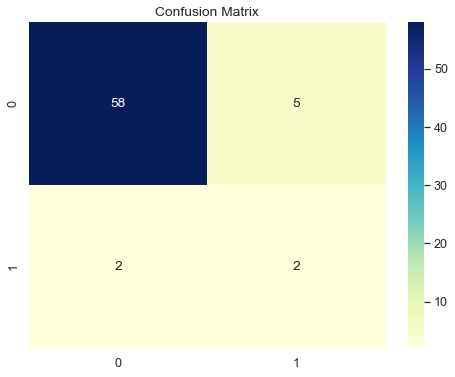

In [196]:
#classifier instances are hyperparameter tuned already
stacking = StackingClassifier(estimators=[('dt',DTClassifier),('svm', SVMClassifier), ('lr', LRClassifier)],
                              final_estimator=LogisticRegression())
stacking.fit(X_train_prep, y_train)

y_val_pred_dt = stacking.predict(X_val_prep)

pred_proba = stacking.predict_proba(X_val)[:,1]
classifier_results(y_val,y_val_pred_dt,pred_proba)

Bagging Ensemble:
- Three different bagging ensemble is tried to idnetify the better performing bagging model


Accuracy: 0.8358 Precision: 0.1818 Recall: 0.5000 F1: 0.2667 ROC-AUC: 0.5000
Accuracy: 0.9403 Precision: 0.5000 Recall: 1.0000 F1: 0.6667 ROC-AUC: 0.5000
Accuracy: 0.7910 Precision: 0.1429 Recall: 0.5000 F1: 0.2222 ROC-AUC: 0.5000


array([[51, 12],
       [ 2,  2]], dtype=int64)

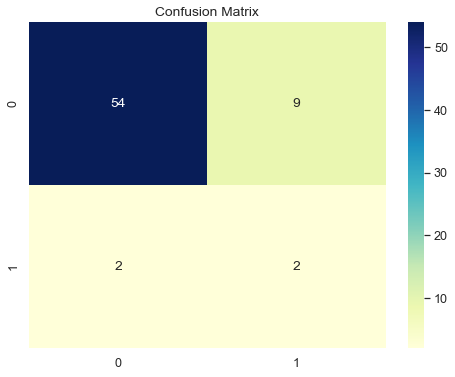

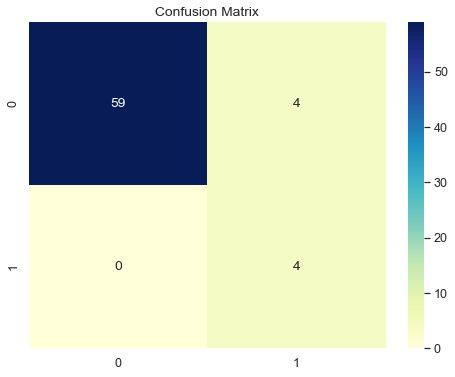

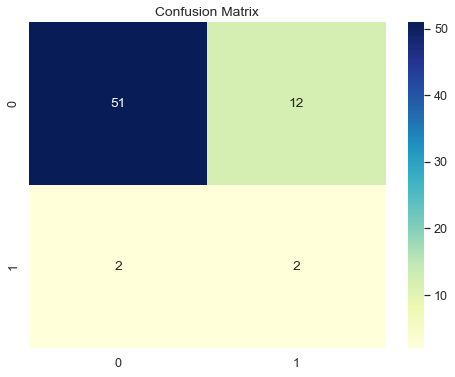

In [197]:
bagging_svm = BaggingClassifier(base_estimator=SVMClassifier, n_estimators=50, random_state=42)
bagging_dt = BaggingClassifier(base_estimator=DTClassifier, n_estimators=50, random_state=42)
bagging_lr = BaggingClassifier(base_estimator=LRClassifier, n_estimators=50, random_state=42)

bagging_svm.fit(X_train_prep, y_train)
bagging_dt.fit(X_train_prep, y_train)
bagging_lr.fit(X_train_prep, y_train)

y_val_pred_svm = bagging_svm.predict(X_val_prep)
y_val_pred_dt = bagging_dt.predict(X_val_prep)
y_val_pred_lr = bagging_lr.predict(X_val_prep)

classifier_results(y_val,y_val_pred_svm,pred_proba)
classifier_results(y_val,y_val_pred_dt,pred_proba)
classifier_results(y_val,y_val_pred_lr,pred_proba)

Voting with Boosting classifiers:
- different boosting models are put together to an voting ensemble. 
- Both the voting types were tried to get the better performing ensemble

0:	learn: 0.6836113	total: 1.87ms	remaining: 1.87s
1:	learn: 0.6746900	total: 3.12ms	remaining: 1.56s
2:	learn: 0.6642450	total: 4.28ms	remaining: 1.42s
3:	learn: 0.6556906	total: 5.41ms	remaining: 1.35s
4:	learn: 0.6460922	total: 6.5ms	remaining: 1.29s
5:	learn: 0.6375291	total: 7.61ms	remaining: 1.26s
6:	learn: 0.6293674	total: 8.68ms	remaining: 1.23s
7:	learn: 0.6220716	total: 9.78ms	remaining: 1.21s
8:	learn: 0.6126475	total: 10.9ms	remaining: 1.2s
9:	learn: 0.6053546	total: 11.9ms	remaining: 1.18s
10:	learn: 0.5968113	total: 13.1ms	remaining: 1.18s
11:	learn: 0.5893048	total: 14.2ms	remaining: 1.17s
12:	learn: 0.5822088	total: 15.3ms	remaining: 1.16s
13:	learn: 0.5748485	total: 16.5ms	remaining: 1.16s
14:	learn: 0.5678205	total: 17.7ms	remaining: 1.16s
15:	learn: 0.5617465	total: 18.8ms	remaining: 1.15s
16:	learn: 0.5542964	total: 19.9ms	remaining: 1.15s
17:	learn: 0.5470502	total: 20.9ms	remaining: 1.14s
18:	learn: 0.5402870	total: 22.1ms	remaining: 1.14s
19:	learn: 0.5322423	tot

310:	learn: 0.1583849	total: 343ms	remaining: 760ms
311:	learn: 0.1580715	total: 344ms	remaining: 759ms
312:	learn: 0.1578606	total: 346ms	remaining: 758ms
313:	learn: 0.1575392	total: 347ms	remaining: 757ms
314:	learn: 0.1573727	total: 348ms	remaining: 756ms
315:	learn: 0.1572424	total: 349ms	remaining: 755ms
316:	learn: 0.1569859	total: 350ms	remaining: 754ms
317:	learn: 0.1569289	total: 351ms	remaining: 753ms
318:	learn: 0.1566992	total: 352ms	remaining: 752ms
319:	learn: 0.1566553	total: 353ms	remaining: 751ms
320:	learn: 0.1563842	total: 354ms	remaining: 750ms
321:	learn: 0.1562053	total: 356ms	remaining: 749ms
322:	learn: 0.1560359	total: 357ms	remaining: 748ms
323:	learn: 0.1558589	total: 358ms	remaining: 747ms
324:	learn: 0.1557661	total: 359ms	remaining: 746ms
325:	learn: 0.1556364	total: 360ms	remaining: 745ms
326:	learn: 0.1554658	total: 361ms	remaining: 744ms
327:	learn: 0.1553841	total: 363ms	remaining: 743ms
328:	learn: 0.1552244	total: 364ms	remaining: 742ms
329:	learn: 

471:	learn: 0.1305997	total: 515ms	remaining: 576ms
472:	learn: 0.1305674	total: 517ms	remaining: 576ms
473:	learn: 0.1304392	total: 518ms	remaining: 575ms
474:	learn: 0.1303435	total: 519ms	remaining: 574ms
475:	learn: 0.1302053	total: 520ms	remaining: 572ms
476:	learn: 0.1300266	total: 521ms	remaining: 571ms
477:	learn: 0.1299439	total: 522ms	remaining: 570ms
478:	learn: 0.1298592	total: 523ms	remaining: 569ms
479:	learn: 0.1297687	total: 525ms	remaining: 568ms
480:	learn: 0.1297277	total: 526ms	remaining: 567ms
481:	learn: 0.1296883	total: 527ms	remaining: 566ms
482:	learn: 0.1294352	total: 528ms	remaining: 566ms
483:	learn: 0.1293923	total: 530ms	remaining: 565ms
484:	learn: 0.1288521	total: 531ms	remaining: 564ms
485:	learn: 0.1287393	total: 532ms	remaining: 562ms
486:	learn: 0.1284970	total: 533ms	remaining: 561ms
487:	learn: 0.1283921	total: 534ms	remaining: 560ms
488:	learn: 0.1282849	total: 535ms	remaining: 559ms
489:	learn: 0.1281745	total: 536ms	remaining: 558ms
490:	learn: 

629:	learn: 0.1115768	total: 686ms	remaining: 403ms
630:	learn: 0.1111752	total: 687ms	remaining: 402ms
631:	learn: 0.1110445	total: 689ms	remaining: 401ms
632:	learn: 0.1110233	total: 690ms	remaining: 400ms
633:	learn: 0.1109895	total: 691ms	remaining: 399ms
634:	learn: 0.1109326	total: 692ms	remaining: 398ms
635:	learn: 0.1108859	total: 693ms	remaining: 397ms
636:	learn: 0.1108685	total: 694ms	remaining: 395ms
637:	learn: 0.1108182	total: 695ms	remaining: 394ms
638:	learn: 0.1107825	total: 696ms	remaining: 393ms
639:	learn: 0.1107670	total: 697ms	remaining: 392ms
640:	learn: 0.1103540	total: 698ms	remaining: 391ms
641:	learn: 0.1102311	total: 699ms	remaining: 390ms
642:	learn: 0.1102118	total: 700ms	remaining: 389ms
643:	learn: 0.1101619	total: 702ms	remaining: 388ms
644:	learn: 0.1101446	total: 703ms	remaining: 387ms
645:	learn: 0.1101284	total: 704ms	remaining: 386ms
646:	learn: 0.1101119	total: 705ms	remaining: 385ms
647:	learn: 0.1099404	total: 706ms	remaining: 384ms
648:	learn: 

943:	learn: 0.0852015	total: 1.03s	remaining: 61ms
944:	learn: 0.0849237	total: 1.03s	remaining: 59.9ms
945:	learn: 0.0848190	total: 1.03s	remaining: 58.9ms
946:	learn: 0.0848056	total: 1.03s	remaining: 57.8ms
947:	learn: 0.0847805	total: 1.03s	remaining: 56.7ms
948:	learn: 0.0847178	total: 1.03s	remaining: 55.6ms
949:	learn: 0.0847086	total: 1.03s	remaining: 54.5ms
950:	learn: 0.0846419	total: 1.04s	remaining: 53.4ms
951:	learn: 0.0845212	total: 1.04s	remaining: 52.3ms
952:	learn: 0.0844166	total: 1.04s	remaining: 51.2ms
953:	learn: 0.0843897	total: 1.04s	remaining: 50.2ms
954:	learn: 0.0843810	total: 1.04s	remaining: 49.1ms
955:	learn: 0.0843261	total: 1.04s	remaining: 48ms
956:	learn: 0.0842777	total: 1.04s	remaining: 46.9ms
957:	learn: 0.0842210	total: 1.04s	remaining: 45.8ms
958:	learn: 0.0842134	total: 1.04s	remaining: 44.7ms
959:	learn: 0.0841885	total: 1.05s	remaining: 43.6ms
960:	learn: 0.0841703	total: 1.05s	remaining: 42.5ms
961:	learn: 0.0841231	total: 1.05s	remaining: 41.5

array([[58,  5],
       [ 0,  4]], dtype=int64)

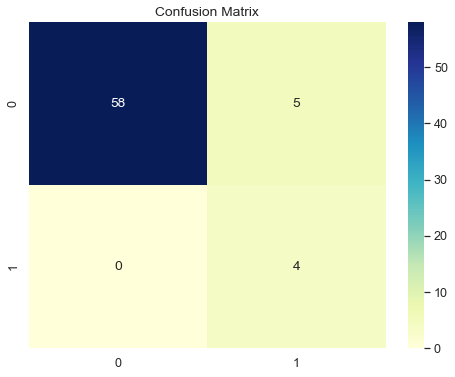

In [198]:
#voting with boosting models
ensemble = VotingClassifier(estimators=[('gbc', GBClassifier), ('abc', ABClassifier), ('cbc', CBClassifier)], voting='soft')
ensemble.fit(X_train_prep, y_train)

y_val_pred = ensemble.predict(X_val_prep)

pred_proba = ensemble.predict_proba(X_val_prep)[:,1]
classifier_results(y_val,y_val_pred,pred_proba)

The best performance of the ensemble models are  


| Ensemble Model | Accuracy | Precision | Recall | F1 | ROC-AUC |
|----------------|----------|-----------|--------|----|---------|
| Stacking| 0.8955 |  0.2857 | 0.5000|0.3636| 0.5000
| Bagging | 0.9403 | 0.5000 | 1.0000|0.6667|0.5000
| Voting(with Boosting models) | 0.9254 | 0.4444 | 1.0000 |0.6154|0.9841|


Among these ensembles, the soft voting with boosting models gives the best performance (ROC- 0.9841 and Accuracy - 0.9254), But the actual performance on the unseen data would give the best ensemble model.

# Testing the models with Test data

Testing with Stacking ensemble

Accuracy: 0.8182 Precision: 0.5000 Recall: 0.6667 F1: 0.5714 ROC-AUC: 0.5000


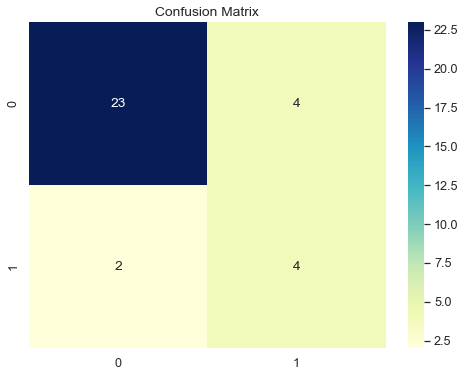

In [199]:
#from sklearn.preprocessing import binarize
#y_pred = binarize(probabilities, threshold=0.2)

y_test_pred = stacking.predict(X_test_prep)
pred_proba = stacking.predict_proba(X_test)[:,0]
test = classifier_results(y_test,y_test_pred,pred_proba)
    

Accuracy: 0.7576 Precision: 0.3750 Recall: 0.5000 F1: 0.4286 ROC-AUC: 0.5000
Accuracy: 0.8182 Precision: 0.5000 Recall: 0.8333 F1: 0.6250 ROC-AUC: 0.5185
Accuracy: 0.8485 Precision: 0.5556 Recall: 0.8333 F1: 0.6667 ROC-AUC: 0.5000


array([[23,  4],
       [ 1,  5]], dtype=int64)

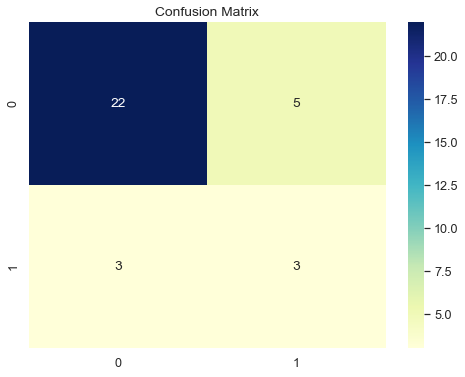

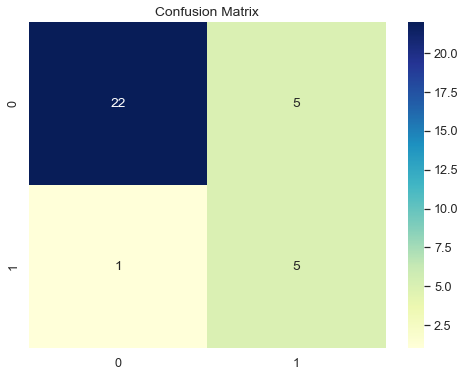

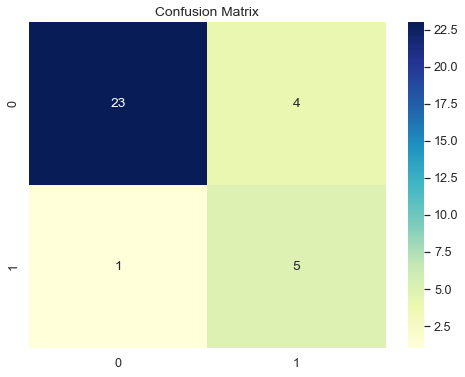

In [200]:
#testing with bagging models
y_test_pred = bagging_lr.predict(X_test_prep)
pred_proba = bagging_lr.predict_proba(X_test)[:,1]
classifier_results(y_test,y_test_pred,pred_proba)

y_test_pred = bagging_svm.predict(X_test_prep)
pred_proba = bagging_svm.predict_proba(X_test)[:,1]
classifier_results(y_test,y_test_pred,pred_proba)

y_test_pred = bagging_dt.predict(X_test_prep)
pred_proba = bagging_dt.predict_proba(X_test)[:,0]
classifier_results(y_test,y_test_pred,pred_proba)


Accuracy: 0.8485 Precision: 0.5714 Recall: 0.6667 F1: 0.6154 ROC-AUC: 0.6821


array([[24,  3],
       [ 2,  4]], dtype=int64)

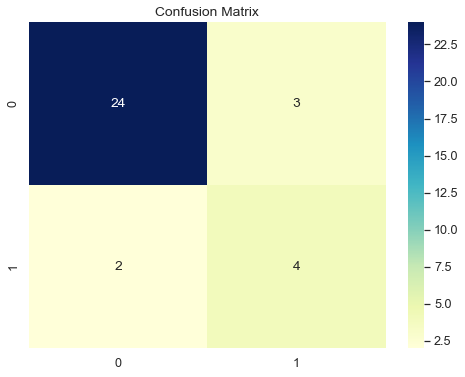

In [201]:
#testing with voting ensemble
y_test_pred = ensemble.predict(X_test_prep)
pred_proba = ensemble.predict_proba(X_test)[:,0]
classifier_results(y_test,y_test_pred,pred_proba)


# Conclusion

The best performing ensemble on unseen data is the voting ensemble (with AdaBoostClassifier,GradientBoostingClassifier and CatBoostClassifier) with

| dataset|Accuracy | Precision | Recall | F1 | ROC-AUC |
|--------|----------|-----------|--------|----|---------|
|Test|0.8485 | 0.5714 | 0.6667 |0.6154|0.6821|
 |validate|0.9254 | 0.4444 | 1.0000 |0.6154|0.9841|
 

Lesser ROC AUC may be due the disproportionate data with very high negative outocme 'Diabetes' to positive outcome. From the outcome of both the validation and testing datsets, the model is predicting the hig_risk patients(recall=1 and 0.6). The precision can be further improved for accurately predicting Negative scenario but in this model, it impacts the Recall and there is a trade off relationship, recall value is considered important as its predicting High risk patients.Therefore I have considered the above as the best performing model.  A number of different combination of the base model and ensembles were tried. The Bagging and Stacking ensemble with different combination of base model (among the ones trained above as well as RandomForest/Naive Bayes models,but has lesser performance) were tried. The voting ensemble gives the best performance comparatively on unseen data with the default sensivity threshold for classification and all other parameters considered for this dataset. 